In [ ]:
!pip install tensorflow tensorflow_hub tensorflow_io librosa scikit-learn matplotlib seaborn tqdm pandas

import os
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import urllib.request
import zipfile
import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 13.1 MB/s eta 0:00:00


In [ ]:
import csv

In [ ]:
# Download and extract ESC-50 dataset
def download_esc50():
    if not os.path.exists('ESC-50'):
        print("Downloading ESC-50 dataset...")
        urllib.request.urlretrieve(
            'https://github.com/karoldvl/ESC-50/archive/master.zip',
            'ESC-50-master.zip'
        )
        print("Extracting dataset...")
        with zipfile.ZipFile('ESC-50-master.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
        os.rename('ESC-50-master', 'ESC-50')
        print("Dataset ready!")
    else:
        print("ESC-50 dataset already available.")

    # Verify audio files exist
    audio_dir = os.path.join('ESC-50', 'audio')
    if not os.path.exists(audio_dir):
        print(f"Warning: Audio directory not found at {audio_dir}")
        # Try alternate path
        if os.path.exists('ESC-50/ESC-50-master/audio'):
            print("Found audio in alternate location")
            audio_dir = 'ESC-50/ESC-50-master/audio'
        else:
            raise FileNotFoundError(f"Could not find audio files. Check directory structure.")

    # Count audio files
    audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]
    print(f"Found {len(audio_files)} audio files")

    return audio_dir

In [ ]:
# Load and process ESC-50 metadata
def load_esc50_metadata():
    metadata_path = os.path.join('ESC-50', 'meta', 'esc50.csv')

    # Check if metadata exists
    if not os.path.exists(metadata_path):
        # Try alternate path
        if os.path.exists('ESC-50/ESC-50-master/meta/esc50.csv'):
            metadata_path = 'ESC-50/ESC-50-master/meta/esc50.csv'
        else:
            raise FileNotFoundError(f"Metadata file not found at {metadata_path}")

    df = pd.read_csv(metadata_path)

    # Define human categories
    human_categories = [
        'crying_baby', 'sneezing', 'clapping', 'breathing',
        'coughing', 'footsteps', 'laughing', 'brushing_teeth',
        'snoring', 'drinking_sipping', 'can_opening', 'car_horn',
        'chainsaw', 'clock_alarm', 'door_wood_creaks', 'door_wood_knock',
        'engine', 'glass_breaking', 'hand_saw', 'keyboard_typing',
        'mouse_click', 'siren', 'toilet_flush'
    ]

    # Add a binary column for human/non-human sounds
    df['is_human'] = df['category'].apply(lambda x: 1 if x in human_categories else 0)

    # Display dataset info
    print(f"Total samples in metadata: {len(df)}")
    print(f"Human sounds: {df['is_human'].sum()}")
    print(f"Non-human sounds: {len(df) - df['is_human'].sum()}")

    return df

In [ ]:
def load_yamnet_model():
    print("Loading YAMNet model...")
    try:
        yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
        # Test the model with random data to catch errors early
        # Create a 1D tensor instead of 2D - this is the key change
        test_audio = np.random.rand(16000).astype(np.float32)
        test_audio = tf.convert_to_tensor(test_audio, dtype=tf.float32)
        # Don't add the extra dimension
        _, emb, _ = yamnet_model(test_audio)
        print("YAMNet model loaded successfully")
        return yamnet_model
    except Exception as e:
        print(f"Error loading YAMNet model: {e}")
        raise


In [ ]:
def predict_with_yamnet(audio_path, yamnet_model, classifier):
    try:
        # Load and resample audio
        audio, sr_orig = librosa.load(audio_path, sr=None, mono=True)
        audio_resampled = librosa.resample(audio, orig_sr=sr_orig, target_sr=16000)

        # Convert to float32 tensor - NO EXTRA DIMENSION
        waveform = tf.convert_to_tensor(audio_resampled, dtype=tf.float32)
        # Don't use tf.expand_dims here

        # Extract YAMNet embeddings
        _, embeddings, _ = yamnet_model(waveform)
        embedding = tf.reduce_mean(embeddings, axis=0).numpy()

        # Make prediction with our classifier
        pred_prob = classifier.predict(embedding.reshape(1, -1))[0]
        pred_label = 1 if pred_prob > 0.5 else 0

        return pred_prob, pred_label, embedding
    except Exception as e:
        print(f"Error processing file {audio_path}: {e}")
        return None, None, None

In [ ]:
# Simple classifier that works with YAMNet embeddings
def create_classifier():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1024,)),  # YAMNet embedding size
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Main function
def main(sample_size=None):
    try:
        # Download dataset if needed
        audio_dir = download_esc50()

        # Load metadata
        df = load_esc50_metadata()

        # Verify file existence before sampling
        print("Verifying audio files...")
        valid_files = []
        for _, row in df.iterrows():
            audio_path = os.path.join(audio_dir, row['filename'])
            if os.path.exists(audio_path):
                valid_files.append(row)
            else:
                print(f"Warning: File not found: {audio_path}")

        # Create new dataframe with only valid files
        if len(valid_files) == 0:
            raise FileNotFoundError("No audio files found matching metadata entries")

        df = pd.DataFrame(valid_files)
        print(f"Found {len(df)} valid audio files with metadata")

        # Optionally sample a subset for faster testing
        if sample_size and sample_size < len(df):
            # Stratified sampling to maintain class balance
            df_human = df[df['is_human'] == 1]
            df_nonhuman = df[df['is_human'] == 0]

            # Calculate how many samples from each class
            n_human = min(int(sample_size * df_human.shape[0] / df.shape[0]), df_human.shape[0])
            n_nonhuman = min(sample_size - n_human, df_nonhuman.shape[0])

            # Sample from each class
            df_human_sample = df_human.sample(n_human, random_state=42)
            df_nonhuman_sample = df_nonhuman.sample(n_nonhuman, random_state=42)

            # Combine samples
            df = pd.concat([df_human_sample, df_nonhuman_sample])
            print(f"Using a stratified sample of {len(df)} files")
            print(f"  Human sounds: {df['is_human'].sum()}")
            print(f"  Non-human sounds: {len(df) - df['is_human'].sum()}")

        # Load YAMNet model
        yamnet_model = load_yamnet_model()

        # Process each audio file to extract YAMNet embeddings
        print("Extracting YAMNet embeddings for each audio file...")

        embeddings = []
        labels = []
        filenames = []
        categories = []

        # Track errors
        error_count = 0
        max_errors = 10
        errors = []

        # Display progress bar
        # In the main function, modify the audio processing loop
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing audio files"):
            audio_path = os.path.join(audio_dir, row['filename'])

            try:
                # Verify file exists
                if not os.path.exists(audio_path):
                    print(f"Skipping missing file: {audio_path}")
                    continue

                # Load and resample audio
                audio, sr_orig = librosa.load(audio_path, sr=None, mono=True)

                # Skip very short files that might cause issues
                if len(audio) < 100:
                    print(f"Skipping too short file: {audio_path}")
                    continue

                audio_resampled = librosa.resample(audio, orig_sr=sr_orig, target_sr=16000)

                # Convert to float32 tensor
                waveform = tf.convert_to_tensor(audio_resampled, dtype=tf.float32)

                # Extract YAMNet embeddings
                _, emb, _ = yamnet_model(waveform)

                # Average across time segments to get a single 1024-dimensional embedding
                embedding = tf.reduce_mean(emb, axis=0).numpy()  # This is the key change

                # Add to our dataset
                embeddings.append(embedding)
                labels.append(row['is_human'])
                filenames.append(row['filename'])
                categories.append(row['category'])

            except Exception as e:
                # Error handling...
                error_count += 1
                errors.append((audio_path, str(e)))
                if error_count <= max_errors:
                    print(f"Error processing {audio_path}: {e}")
                if error_count == max_errors:
                    print("Too many errors, suppressing further error messages...")

        # Check if we have enough data
        if len(embeddings) == 0:
            print(f"No embeddings extracted successfully. Found {error_count} errors.")
            if errors:
                print("First few errors:")
                for path, err in errors[:5]:
                    print(f"  {path}: {err}")
            raise ValueError("No valid embeddings could be extracted from the audio files")

        print(f"Successfully processed {len(embeddings)} files")
        print(f"Encountered {error_count} errors")

        # Convert to numpy arrays
        X = np.array(embeddings)
        y = np.array(labels)

        print(f"Shape of embeddings: {X.shape}, Labels: {y.shape}")
        print(f"Class distribution: {np.bincount(y)}")

        # Split data into train and test sets with stratification
        X_train, X_test, y_train, y_test, filenames_train, filenames_test, categories_train, categories_test = train_test_split(
            X, y, filenames, categories, test_size=0.2, random_state=42, stratify=y
        )

        print(f"Training set: {len(X_train)} samples (Human: {sum(y_train)}, Non-human: {len(y_train) - sum(y_train)})")
        print(f"Test set: {len(X_test)} samples (Human: {sum(y_test)}, Non-human: {len(y_test) - sum(y_test)})")

        # Create and train classifier
        print("Training classifier...")
        classifier = create_classifier()

        history = classifier.fit(
            X_train, y_train,
            epochs=30,
            validation_split=0.2,
            batch_size=32,
            callbacks=[tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=5,
                restore_best_weights=True
            )],
            verbose=1
        )

        # Plot training history
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(SAVE_DIR, 'training_history_simple.png'))
        plt.show()

        # Evaluate model on test set
        print("Evaluating model...")

        # Make predictions
        y_pred_prob = classifier.predict(X_test).flatten()
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Non-Human', 'Human'],
                    yticklabels=['Non-Human', 'Human'])
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig(os.path.join(SAVE_DIR, 'confusion_matrix_simple.png'))
        plt.show()

        # Save model
        classifier.save(os.path.join(SAVE_DIR, 'yamnet_simple_classifier.h5'))

        # Create results DataFrame
        results = []
        for i in range(len(X_test)):
            results.append({
                'filename': filenames_test[i],
                'category': categories_test[i],
                'true_label': y_test[i],
                'predicted_label': y_pred[i],
                'probability': y_pred_prob[i]
            })

        results_df = pd.DataFrame(results)

        # Save results
        results_df.to_csv(os.path.join(SAVE_DIR, 'yamnet_simple_results.csv'), index=False)

        # Print per-category performance
        print("\nPer-category performance:")
        category_metrics = {}
        for category in sorted(results_df['category'].unique()):
            cat_results = results_df[results_df['category'] == category]
            if len(cat_results) > 0:
                cat_acc = accuracy_score(cat_results['true_label'], cat_results['predicted_label'])
                is_human = "Human" if cat_results['true_label'].iloc[0] == 1 else "Non-human"
                print(f"{category} ({is_human}): Accuracy = {cat_acc:.4f}")
                category_metrics[category] = cat_acc

        return classifier, yamnet_model, results_df, accuracy

    except Exception as e:
        import traceback
        print(f"Error in main function: {e}")
        traceback.print_exc()
        raise


In [ ]:
# Function to analyze misclassifications
def analyze_misclassifications(results_df):
    """Analyze and visualize misclassifications"""
    print("\nAnalyzing misclassifications...")

    # Filter misclassified examples
    misclassified = results_df[results_df['true_label'] != results_df['predicted_label']]
    print(f"Total misclassifications: {len(misclassified)} out of {len(results_df)} ({len(misclassified)/len(results_df)*100:.2f}%)")

    # Group by category
    misclass_by_category = misclassified.groupby('category').size().reset_index(name='count')
    misclass_by_category = misclass_by_category.sort_values('count', ascending=False)

    # Calculate misclassification rate per category
    category_counts = results_df.groupby('category').size()
    misclass_by_category['total'] = misclass_by_category['category'].map(category_counts)
    misclass_by_category['misclass_rate'] = misclass_by_category['count'] / misclass_by_category['total']

    # Display top problematic categories
    print("\nTop 5 categories with highest misclassification rate:")
    top_categories = misclass_by_category.sort_values('misclass_rate', ascending=False).head(5)
    for _, row in top_categories.iterrows():
        print(f"{row['category']}: {row['misclass_rate']*100:.2f}% ({row['count']} out of {row['total']})")

    # Plot misclassification rates
    plt.figure(figsize=(12, 6))

    # Get top 10 categories by misclassification rate
    top10 = misclass_by_category.sort_values('misclass_rate', ascending=False).head(10)

    sns.barplot(x='misclass_rate', y='category', data=top10)
    plt.title('Top 10 Categories by Misclassification Rate')
    plt.xlabel('Misclassification Rate')
    plt.ylabel('Category')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'misclassification_rates.png'))
    plt.show()

    # Plot confidence distribution for correct vs incorrect predictions
    plt.figure(figsize=(10, 6))

    # For human sounds
    plt.subplot(1, 2, 1)
    human_correct = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 1)]
    human_incorrect = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 0)]

    if len(human_correct) > 0:
        sns.histplot(human_correct['probability'], color='green', alpha=0.5, label='Correct')
    if len(human_incorrect) > 0:
        sns.histplot(human_incorrect['probability'], color='red', alpha=0.5, label='Incorrect')

    plt.title('Human Sounds: Prediction Probabilities')
    plt.xlabel('Probability of Human Sound')
    plt.legend()

    # For non-human sounds
    plt.subplot(1, 2, 2)
    nonhuman_correct = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 0)]
    nonhuman_incorrect = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 1)]

    if len(nonhuman_correct) > 0:
        sns.histplot(1 - nonhuman_correct['probability'], color='green', alpha=0.5, label='Correct')
    if len(nonhuman_incorrect) > 0:
        sns.histplot(1 - nonhuman_incorrect['probability'], color='red', alpha=0.5, label='Incorrect')

    plt.title('Non-Human Sounds: Prediction Probabilities')
    plt.xlabel('Probability of Non-Human Sound')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'prediction_confidence.png'))
    plt.show()

    return misclass_by_category

In [ ]:
# Function to perform inference on new audio files
def infer_on_audio(audio_path, yamnet_model, classifier):
    """
    Run inference on a single audio file
    Returns prediction, probability, and embedding
    """
    try:
        # Load and resample audio
        audio, sr_orig = librosa.load(audio_path, sr=None, mono=True)
        audio_resampled = librosa.resample(audio, orig_sr=sr_orig, target_sr=16000)

        # Get audio duration
        duration = len(audio) / sr_orig
        print(f"Audio duration: {duration:.2f} seconds")

        # Convert to tensor
        waveform = tf.convert_to_tensor(audio_resampled, dtype=tf.float32)

        # Extract YAMNet embeddings and scores
        scores, embeddings, log_mel_spectrogram = yamnet_model(waveform)
        embedding = tf.reduce_mean(embeddings, axis=0).numpy()

        # Get YAMNet class names from the labels file
        # We need to download it separately
        class_map_path = tf.keras.utils.get_file('yamnet_class_map.csv',
                                                'https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/yamnet/yamnet_class_map.csv')
        yamnet_classes = []
        with open(class_map_path, 'r') as f:
            reader = csv.reader(f)
            next(reader)  # Skip header
            for row in reader:
                yamnet_classes.append(row[2])

        # Get YAMNet class predictions (top 5)
        mean_scores = tf.reduce_mean(scores, axis=0)
        yamnet_top_classes = tf.math.top_k(mean_scores, k=5)

        print("\nYAMNet classification (general audio classes):")
        for i in range(5):
            index = yamnet_top_classes.indices[i].numpy()
            score = yamnet_top_classes.values[i].numpy()
            label = yamnet_classes[index]
            print(f"{i+1}. {label}: {score:.3f}")

        # Make prediction with our human/non-human classifier
        pred_prob = classifier.predict(embedding.reshape(1, -1), verbose=0)[0][0]
        pred_label = 1 if pred_prob > 0.5 else 0

        prediction = "Human" if pred_label == 1 else "Non-Human"
        confidence = pred_prob if pred_label == 1 else 1 - pred_prob

        print(f"\nHuman Sound Detector:")
        print(f"Prediction: {prediction} sound with {confidence:.4f} confidence")

        # Visualize the log mel spectrogram
        plt.figure(figsize=(10, 4))
        plt.imshow(tf.transpose(log_mel_spectrogram[0])[..., tf.newaxis], aspect='auto', origin='lower')
        plt.title('Log Mel Spectrogram')
        plt.ylabel('Mel Bands')
        plt.xlabel('Time')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.savefig(os.path.join(SAVE_DIR, 'spectrogram.png'))
        plt.show()

        return pred_label, pred_prob, embedding

    except Exception as e:
        print(f"Error processing audio file: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

In [ ]:
# Function to analyze specific categories
def analyze_category(category, results_df, audio_dir, yamnet_model):
    """Analyze a specific category in detail"""
    category_data = results_df[results_df['category'] == category]

    if len(category_data) == 0:
        print(f"No data available for category: {category}")
        return

    print(f"\nAnalyzing category: {category}")
    print(f"Total samples: {len(category_data)}")
    print(f"True label: {'Human' if category_data['true_label'].iloc[0] == 1 else 'Non-Human'}")

    acc = accuracy_score(category_data['true_label'], category_data['predicted_label'])
    print(f"Accuracy: {acc:.4f}")

    # Show distribution of prediction probabilities
    plt.figure(figsize=(8, 5))
    sns.histplot(category_data['probability'], bins=20)
    plt.title(f'Prediction Distribution for {category}')
    plt.xlabel('Probability of Human Sound')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, f'category_{category}_distribution.png'))
    plt.show()

    # Show most confidently correct and incorrect examples
    if len(category_data[category_data['true_label'] == category_data['predicted_label']]) > 0:
        correct = category_data[category_data['true_label'] == category_data['predicted_label']]
        most_confident = correct.iloc[correct['probability'].argmax()]
        print("\nMost confident correct prediction:")
        print(f"Filename: {most_confident['filename']}")
        print(f"Probability: {most_confident['probability']:.4f}")

    if len(category_data[category_data['true_label'] != category_data['predicted_label']]) > 0:
        incorrect = category_data[category_data['true_label'] != category_data['predicted_label']]
        most_mistaken = incorrect.iloc[incorrect['probability'].argmax() if category_data['true_label'].iloc[0] == 0 else incorrect['probability'].argmin()]
        print("\nMost confident incorrect prediction:")
        print(f"Filename: {most_mistaken['filename']}")
        print(f"Probability: {most_mistaken['probability']:.4f}")

In [ ]:
# Save and load model utilities
def save_model_and_metadata(classifier, results_df, model_dir=None):
    """Save model, results, and metadata"""
    if model_dir is None:
        model_dir = os.path.join(SAVE_DIR, 'model_export')

    os.makedirs(model_dir, exist_ok=True)

    # Save model
    model_path = os.path.join(model_dir, 'human_sound_classifier.h5')
    classifier.save(model_path)

    # Save results
    results_path = os.path.join(model_dir, 'evaluation_results.csv')
    results_df.to_csv(results_path, index=False)

    # Save metadata with timestamp
    import datetime
    metadata = {
        'created': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'accuracy': accuracy_score(results_df['true_label'], results_df['predicted_label']),
        'human_samples': int(results_df['true_label'].sum()),
        'nonhuman_samples': int(len(results_df) - results_df['true_label'].sum()),
        'model_path': model_path,
        'results_path': results_path
    }

    with open(os.path.join(model_dir, 'metadata.json'), 'w') as f:
        import json
        json.dump(metadata, f, indent=2)

    print(f"Model and metadata saved to {model_dir}")
    return model_dir

In [ ]:
def load_trained_model(model_path):
    """Load a previously trained model"""
    try:
        classifier = tf.keras.models.load_model(model_path)
        print(f"Model loaded from {model_path}")
        return classifier
    except Exception as e:
        print(f"Error loading model: {e}")
        return None


In [ ]:
# Web demonstration utility (for Colab)
def create_demo_interface():
    """Create a simple demo interface for Colab"""
    if not IN_COLAB:
        print("Demo interface is only available in Colab")
        return

    from google.colab import files
    from IPython.display import display, Audio, HTML
    import ipywidgets as widgets

    upload_button = widgets.Button(description="Upload Audio")
    output = widgets.Output()

    def on_upload_button_clicked(b):
        with output:
            clear_output()
            print("Upload an audio file...")
            uploaded = files.upload()

            if uploaded:
                for filename, content in uploaded.items():
                    # Save the uploaded file
                    with open(filename, 'wb') as f:
                        f.write(content)

                    print(f"Processing {filename}...")

                    # Display audio player
                    display(Audio(filename))

                    # Process with YAMNet and classifier
                    pred_label, pred_prob, _ = infer_on_audio(filename, yamnet_model, classifier)

                    if pred_label is not None:
                        prediction = "Human" if pred_label == 1 else "Non-Human"
                        confidence = pred_prob if pred_label == 1 else 1 - pred_prob

                        # Display result with formatted HTML
                        result_html = f"""
                        <div style="background-color: #f0f0f0; padding: 15px; border-radius: 5px; margin: 10px 0;">
                            <h3 style="margin-top: 0;">Prediction Results</h3>
                            <p><b>Classification:</b> {prediction} sound</p>
                            <p><b>Confidence:</b> {confidence:.2%}</p>
                        </div>
                        """
                        display(HTML(result_html))

    upload_button.on_click(on_upload_button_clicked)

    print("Demo Interface for Human Sound Classification")
    print("---------------------------------------------")
    print("Click the button below to upload an audio file for classification")

    display(upload_button, output)


ESC-50 dataset already available.
Found 2000 audio files
Total samples in metadata: 2000
Human sounds: 920
Non-human sounds: 1080
Verifying audio files...
Found 2000 valid audio files with metadata
Using a stratified sample of 1000 files
  Human sounds: 460
  Non-human sounds: 540
Loading YAMNet model...
YAMNet model loaded successfully
Extracting YAMNet embeddings for each audio file...


Processing audio files:   0%|          | 0/1000 [00:00<?, ?it/s]

Successfully processed 1000 files
Encountered 0 errors
Shape of embeddings: (1000, 1024), Labels: (1000,)
Class distribution: [540 460]
Training set: 800 samples (Human: 368, Non-human: 432)
Test set: 200 samples (Human: 92, Non-human: 108)
Training classifier...
Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7024 - loss: 0.7381 - val_accuracy: 0.8375 - val_loss: 0.4394
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8425 - loss: 0.4213 - val_accuracy: 0.8562 - val_loss: 0.4273
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8492 - loss: 0.4795 - val_accuracy: 0.8687 - val_loss: 0.3219
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8904 - loss: 0.2887 - val_accuracy: 0.9000 - val_loss: 0.2390
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8966 - loss: 0.2778 - val_accuracy: 0.9312 - val_loss: 0.2219
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9270 - loss: 0.2346 - val_accuracy: 

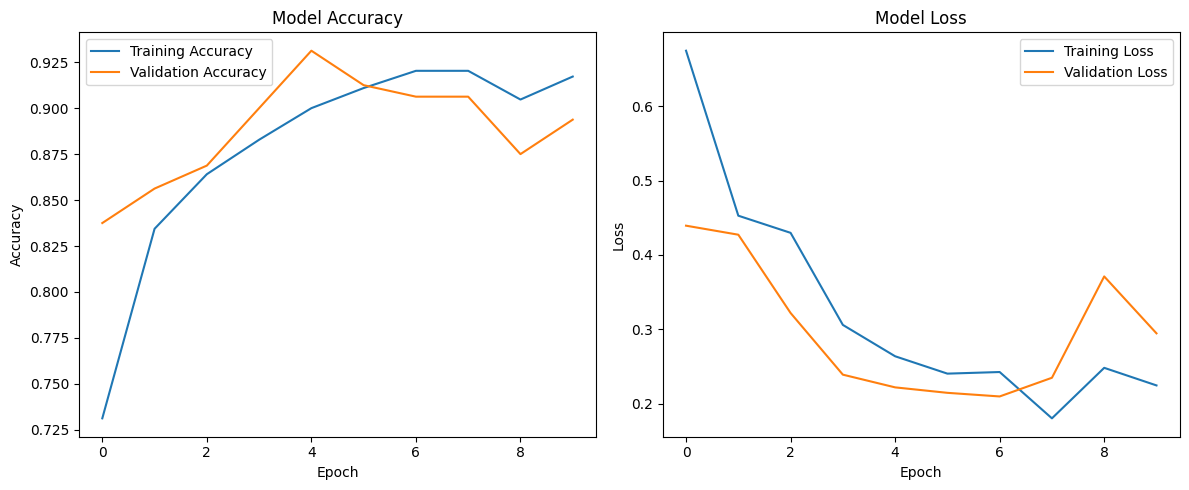

Evaluating model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test Accuracy: 0.9250
Precision: 0.8812
Recall: 0.9674
F1 Score: 0.9223


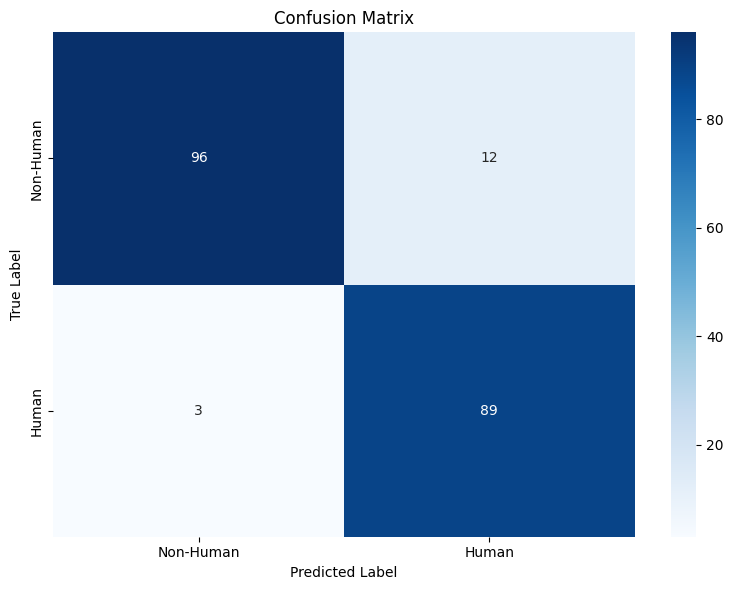


Per-category performance:
airplane (Non-human): Accuracy = 1.0000
breathing (Human): Accuracy = 1.0000
brushing_teeth (Human): Accuracy = 1.0000
can_opening (Human): Accuracy = 1.0000
car_horn (Human): Accuracy = 1.0000
cat (Non-human): Accuracy = 1.0000
chainsaw (Human): Accuracy = 1.0000
chirping_birds (Non-human): Accuracy = 1.0000
church_bells (Non-human): Accuracy = 1.0000
clapping (Human): Accuracy = 1.0000
clock_alarm (Human): Accuracy = 1.0000
clock_tick (Non-human): Accuracy = 0.8000
coughing (Human): Accuracy = 1.0000
cow (Non-human): Accuracy = 1.0000
crackling_fire (Non-human): Accuracy = 1.0000
crickets (Non-human): Accuracy = 0.7500
crow (Non-human): Accuracy = 1.0000
crying_baby (Human): Accuracy = 1.0000
dog (Non-human): Accuracy = 0.5000
door_wood_creaks (Human): Accuracy = 1.0000
door_wood_knock (Human): Accuracy = 1.0000
drinking_sipping (Human): Accuracy = 1.0000
engine (Human): Accuracy = 1.0000
fireworks (Non-human): Accuracy = 1.0000
footsteps (Human): Accuracy 

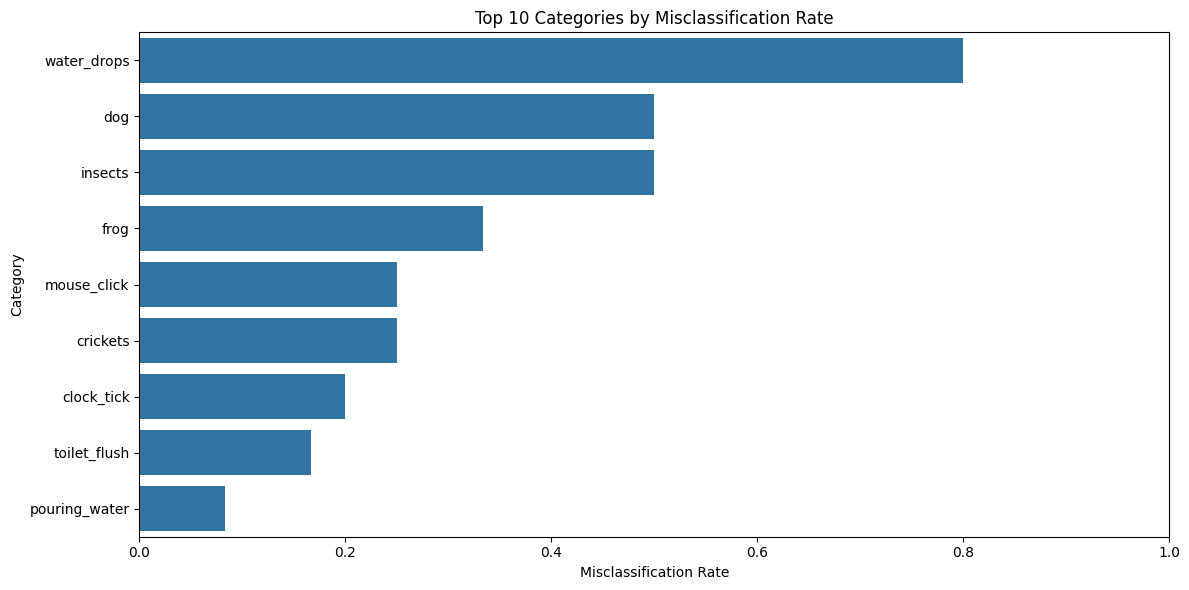

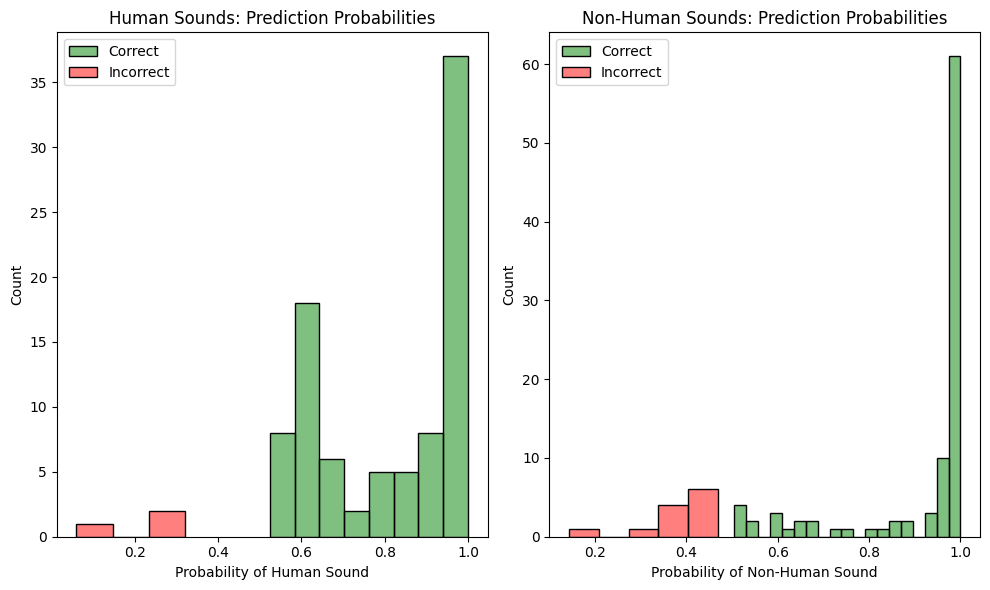

Model and metadata saved to /content/drive/MyDrive/YAMNet_ESC50_Results/model_export

Process completed successfully!
You can now use the following functions:
1. infer_on_audio(audio_path, yamnet_model, classifier) - Classify a new audio file
2. analyze_category(category, results_df, audio_dir, yamnet_model) - Analyze results for a specific category
3. create_demo_interface() - Create an interactive demo (Colab only)


In [ ]:
# Run the main function with a sample size
if __name__ == "__main__":
    try:
        # Start with a smaller sample for initial testing
        classifier, yamnet_model, results_df, accuracy = main(sample_size=1000)
        print(f"\nFinal accuracy: {accuracy:.4f}")

        # Analyze misclassifications
        misclass_analysis = analyze_misclassifications(results_df)

        # Save the model
        model_dir = save_model_and_metadata(classifier, results_df)

        print("\nProcess completed successfully!")
        print("You can now use the following functions:")
        print("1. infer_on_audio(audio_path, yamnet_model, classifier) - Classify a new audio file")
        print("2. analyze_category(category, results_df, audio_dir, yamnet_model) - Analyze results for a specific category")
        print("3. create_demo_interface() - Create an interactive demo (Colab only)")

    except Exception as e:
        print(f"Error running main function: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
# If in Colab, offer to create the demo interface

create_interface = input("\nWould you like to create the demo interface? (y/n): ")
if create_interface.lower() == 'y':
    create_demo_interface()


Would you like to create the demo interface? (y/n): y
Demo Interface for Human Sound Classification
---------------------------------------------
Click the button below to upload an audio file for classification


Button(description='Upload Audio', style=ButtonStyle())

Output()